<a href="https://colab.research.google.com/github/Maheshtanni/Stakeholder-sentiment/blob/main/Stakeholdersentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install nltk pandas matplotlib wordcloud
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import nltk; nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/stakeholder_feedback_day16.csv')  # ensure file is in Colab working dir
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
sia = SentimentIntensityAnalyzer()
scores = df['Comment'].apply(sia.polarity_scores).apply(pd.Series)
df = pd.concat([df, scores], axis=1)
df['Predicted_Sentiment'] = np.select(
    [df['compound'] >= 0.05, df['compound'] <= -0.05],
    ['positive','negative'],
    default='neutral'
)

In [ ]:
by_dept = (df.groupby(['Department','Predicted_Sentiment'])
             .size().unstack(fill_value=0).reindex(sorted(df['Department'].unique())))
by_dept['Total'] = by_dept.sum(axis=1)
by_dept_pct = (by_dept[['positive','neutral','negative']].div(by_dept['Total'], axis=0)*100).round(1)
by_dept_pct.to_csv('sentiment_by_department_percent.csv')

overall = df['Predicted_Sentiment'].value_counts(normalize=True).mul(100).round(1)
overall.to_csv('sentiment_overall_percent.csv')

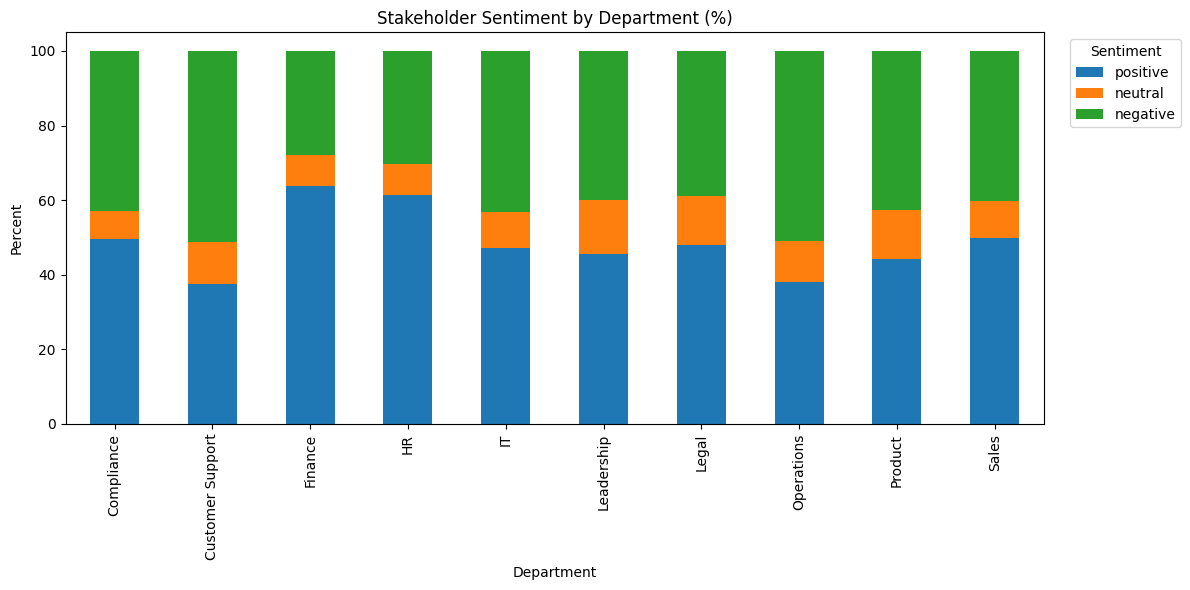

In [ ]:
ax = by_dept_pct[['positive','neutral','negative']].plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Stakeholder Sentiment by Department (%)')
plt.ylabel('Percent'); plt.xlabel('Department'); plt.legend(title='Sentiment', bbox_to_anchor=(1.02,1))
plt.tight_layout(); plt.savefig('chart_sentiment_by_dept.png', dpi=160); plt.show()

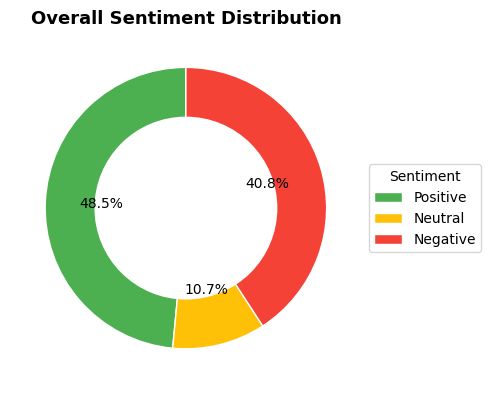

In [ ]:
sizes = overall[['positive','neutral','negative']].reindex(['positive','neutral','negative']).values
labels = ['Positive','Neutral','Negative']
colors = ['#4CAF50', '#FFC107', '#F44336']  # green, amber, red

fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    sizes, labels=None, colors=colors, startangle=90, autopct='%1.1f%%',
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add donut hole
centre_circle = plt.Circle((0,0),0.65,fc='white')
fig.gca().add_artist(centre_circle)

# Add legend and title
ax.legend(wedges, labels, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Overall Sentiment Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('chart_overall_donut.png', dpi=160)
plt.show()


/tmp/ipython-input-1592884389.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq='M'))['Predicted_Sentiment']
/tmp/ipython-input-1592884389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_month['pct'] = (neg_month['pct']*100).round(1)


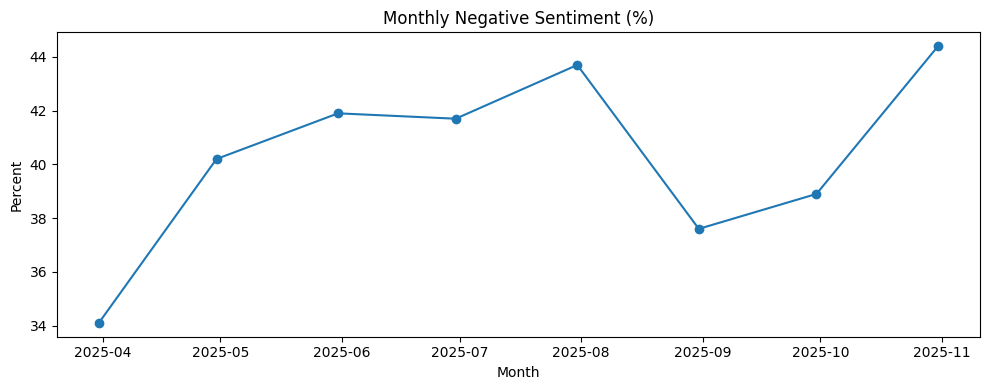

In [ ]:
monthly = (df.set_index('Date')
             .groupby(pd.Grouper(freq='M'))['Predicted_Sentiment']
             .value_counts(normalize=True)
             .rename('pct').reset_index())
neg_month = monthly[monthly['Predicted_Sentiment']=='negative']
neg_month['pct'] = (neg_month['pct']*100).round(1)
plt.figure(figsize=(10,4))
plt.plot(neg_month['Date'], neg_month['pct'], marker='o')
plt.title('Monthly Negative Sentiment (%)'); plt.ylabel('Percent'); plt.xlabel('Month')
plt.tight_layout(); plt.savefig('chart_negative_trend.png', dpi=160); plt.show()

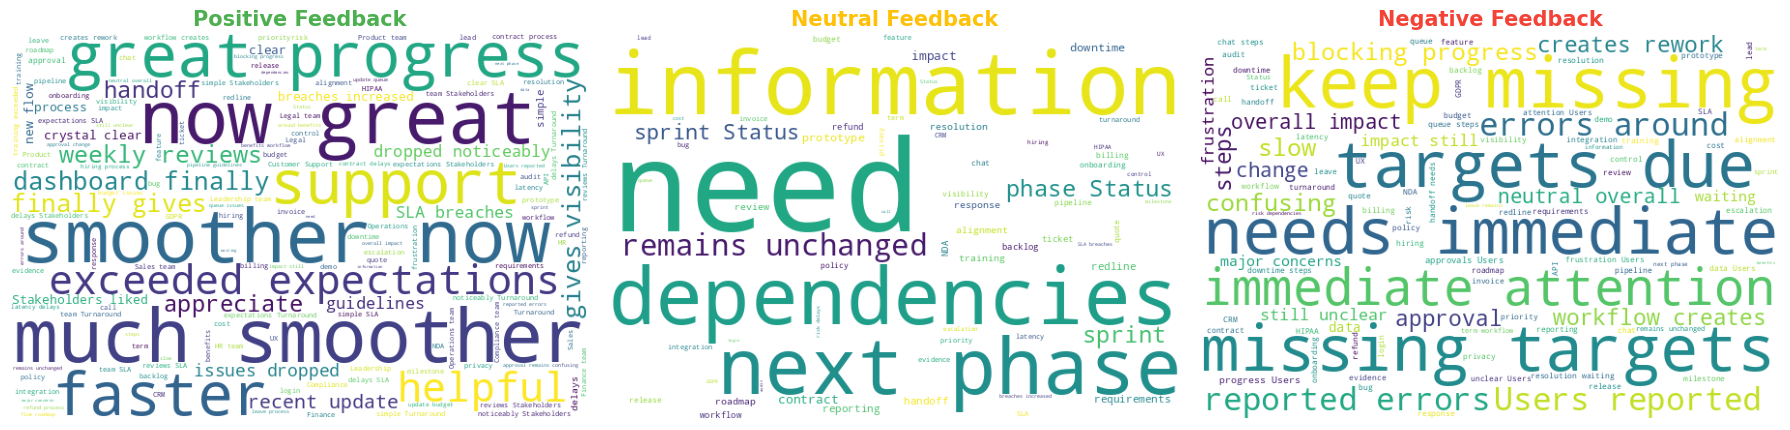

In [ ]:
sentiments = ['positive','neutral','negative']
colors = ['#4CAF50','#FFC107','#F44336']

fig, axes = plt.subplots(1,3,figsize=(18,6))
for ax, s, c in zip(axes, sentiments, colors):
    text = " ".join(df.loc[df['Predicted_Sentiment']==s, 'Comment'])
    wc = WordCloud(width=600, height=400, background_color='white').generate(text)
    ax.imshow(wc); ax.axis('off')
    ax.set_title(f"{s.title()} Feedback", color=c, fontsize=15, fontweight='bold')

plt.tight_layout(); plt.savefig('wordcloud_all_sentiments.png', dpi=160); plt.show()


In [ ]:
themes = (df.groupby(['Department','Theme'])['Comment'].count()
            .reset_index(name='Count').sort_values(['Department','Count'], ascending=[True, False]))
themes.to_csv('top_themes_by_dept.csv', index=False)